# Naive Bayes with uni, bi, and tri gram, and unsupervised gensim embeddings

## imports

In [17]:
import string
from os import listdir
from os.path import isfile, join

import nltk
from nltk import word_tokenize
from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer


# Gensim is an open-source library for unsupervised topic modeling
import gensim
from gensim.models.keyedvectors import BaseKeyedVectors
import gensim.downloader as api
#  Fast Sentence Embeddings serves as an addition to Gensim.
#  it compute sentence vectors for large collections of sentences.
from fse import IndexedList
glove = api.load("glove-wiki-gigaword-100")
from fse.models import uSIF
#Unsupervised smooth-inverse frequency (uSIF) weighted sentence embeddings model.
# Performs a weighted averaging operation over all words in a sentences.
# After training, the model removes a number of weighted singular vectors.


nltk.download('opinion_lexicon')
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### setup puncuation and contractions to help clean text

In [3]:
punctuation = string.punctuation
positive_dict = set(opinion_lexicon.positive())
negative_dict = set(opinion_lexicon.negative())
positive_dict_stemmed = [PorterStemmer().stem(word) for word in positive_dict]
negative_dict_stemmed = [PorterStemmer().stem(word) for word in negative_dict]

contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

### functions to help get data from txt files and to process and clean data

In [4]:
def get_files_from_dir(directory):
    return [f for f in listdir(directory) if isfile(join(directory, f))]

def process_string_sentence(text):
        englishStopwords = stopwords.words("english")  # non-neccesary words
        text = text.lower()  # case folding
        # remove punctuation
        text = "".join([char for char in text if char not in punctuation])
        words = word_tokenize(text)
        removed = [word for word in words if word not in englishStopwords]
        stemmed = [PorterStemmer().stem(word) for word in removed]
        stemmed_sentence = " ".join(stemmed)
        return stemmed_sentence

def process_string(text):
        englishStopwords = stopwords.words("english")  # non-neccesary words
        text = text.lower()  # case folding
        # remove punctuation
        text = "".join([char for char in text if char not in punctuation])
        words = word_tokenize(text)
        removed = [word for word in words if word not in englishStopwords]
        return [", ".join(removed)]


def tokenize_files(files, dir):
        cleaned_positive_files = []
        for file in files:
            file_path = str.format("{}/{}", dir, file)
            with open(file_path) as f:
                raw_text = f.read()
                cleaned_positive_files.append(process_string(raw_text))
        return cleaned_positive_files

def is_word_positive(word):
        if word in positive_dict or word in positive_dict_stemmed:
            return True
        return False

def is_word_negative(word):
    if word in negative_dict or word in negative_dict_stemmed:
        return True
    return False



def get_word_occurrences(tokenized_files):
        word_occurrences = {}
        word_occurrences["positive"] = 0
        word_occurrences["negative"] = 0
        total_num_words = 0
        for file in tokenized_files:
            # calc number exclams
            # calc number pos/neg/words
            for word in file:
                if is_word_positive(word):
                    word_occurrences["positive"] += 1
                if is_word_negative(word):
                    word_occurrences["negative"] += 1
                if word not in word_occurrences:
                    word_occurrences[word] = 0
                word_occurrences[word] += 1
                total_num_words += 1
        return word_occurrences, total_num_words

def get_raw_text_from_files(files: list, dir: str) -> list:
    raw_text = []
    for file in files:
        file_path = str.format("{}/{}", dir, file)
        with open(file_path) as f:
            file_text_in_lines = f.read()
            raw_text.append(file_text_in_lines)
    return raw_text

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''

    # Convert words to lower case
    text = text.lower()

    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)

    return text


### gather and clean data 

In [13]:
neg_data = np.array(get_raw_text_from_files(get_files_from_dir("./data/neg"), "data/neg"))
pos_data = np.array(get_raw_text_from_files(get_files_from_dir("./data/pos"), "data/pos"))
allData = np.concatenate((neg_data, pos_data))
# making labels for the data, the first
neg_labels = np.fromiter([0 for i in range(len(neg_data))], int)  # create negative labels
pos_labels = np.fromiter([1 for i in range(len(pos_data))], int)  # create positive labels
allLabels = np.concatenate((neg_labels, pos_labels))

xy = []
for data in allData:
    xy.append(clean_text(data))

allData = np.array(xy)

/var/folders/zz/yhmtwxfj489c3r52w8d8rqnr0000gn/T/ipykernel_20783/3347398088.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allData = np.array(xy)


array([list(['ordered', 'hp4705', 'bluetooth', 'keyboard', 'sent', 'two', 'non', 'bluetooth', 'item', 'send', 'back', 'hope', 'get', 'credit']),
       list(['hoping', 'buy', 'small', 'handheld', 'vacuum', 'office', 'computer', 'hardware', 'keyboads', 'air', 'inlets', 'however', 'datavac', 'little', 'power', 'even', 'full', 'charge', 'next', 'useless', 'cannot', 'recommend']),
       list(['bought', '3', 'vtech', 'phones', 'house', 'since', 'begining', 'battery', 'problems', 'really', 'annoying', 'make', 'phone', 'call', 'phone', 'work', 'battery', 'point', 'time', 'least', 'one', 'phones', 'constantly', 'reports', 'low', 'charge', 'battery', 'message', 'means', 'cannot', 'use', 'phone', 'course', 'hear', 'ring', 'phone', 'never', 'room', 'run', 'pick', 'phone', 'since', 'one', 'location', 'battery', 'problem', 'reviewers', 'noted', 'spite', 'fact', 'make', 'minimal', 'use', 'phones', 'leave', 'charger', 'time', 'beginning', 'used', 'take', 'battery', 'phone', 'put', 'back', 'quite', '

### function to run naive bayes model with the given bow converter and data

In [43]:


def run_naive(allData, description,  bow_converter, _C=1.0,):
    kf = KFold(n_splits=5, shuffle=True)
    uSIF_model = uSIF(glove, workers=2, lang_freq="en")
    for trainingIndex, testingIndex in kf.split(allData):
        # get the train/test labels and data from split
        trainingData, testingData = allData[trainingIndex], allData[testingIndex]
        trainingLabels, testingLabels = allLabels[trainingIndex], allLabels[testingIndex]

        # convert the 
        trainingData = bow_converter.fit_transform(trainingData)
        testingData = bow_converter.transform(testingData)
        
        trainingData = trainingData.toarray() 
        testingData = testingData.toarray()
        
        # train naive bayes model
        model = GaussianNB()
        model.fit(trainingData, trainingLabels)


        # get the model score
        score = model.score(testingData, testingLabels)
        print(description, " model score: ", score)

        # get label prediction
        labelPrediction = model.predict_proba(testingData)[:, 1]

        # use prediction to get metrics
        precision, recall, thresholds = precision_recall_curve(testingLabels, labelPrediction)
        average_precision = average_precision_score(testingLabels, labelPrediction)

        # plot curve
        disp = plot_precision_recall_curve(model, testingData, testingLabels)
        disp.ax_.set_title('2-class Precision-Recall curve: '
                        'AP={0:0.2f}'.format(average_precision))



def run_naive_sentence_embeddings(allData, description, _C=1.0,):
    kf = KFold(n_splits=5, shuffle=True)
    uSIF_model = uSIF(glove, workers=2, lang_freq="en")
    for trainingIndex, testingIndex in kf.split(allData):
        # get the train/test labels and data from split
        trainingData, testingData = allData[trainingIndex], allData[testingIndex]
        trainingLabels, testingLabels = allLabels[trainingIndex], allLabels[testingIndex]

        # train embeddings model
        uSIF_model.train(IndexedList(trainingData))

        train_embed = uSIF_model.infer(IndexedList(trainingData))  # sentence vectors for training
        test_embed = uSIF_model.infer(IndexedList(testingData))  # sentence vectors for testing

        # train naive bayes model
        model = GaussianNB()
        model.fit(train_embed, trainingLabels)


        # get the model score
        score = model.score(test_embed, testingLabels)
        print(description, " model score: ", score)

        # get label prediction
        labelPrediction = model.predict_proba(test_embed)[:, 1]

        # use prediction to get metrics
        precision, recall, thresholds = precision_recall_curve(testingLabels, labelPrediction)
        average_precision = average_precision_score(testingLabels, labelPrediction)

        # plot curve
        disp = plot_precision_recall_curve(model, test_embed, testingLabels)
        disp.ax_.set_title('2-class Precision-Recall curve: '
                        'AP={0:0.2f}'.format(average_precision))




### run naive on unigram BOW

unigram BOW  model score:  0.5975


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.6075


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.6125


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.595


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.6175


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


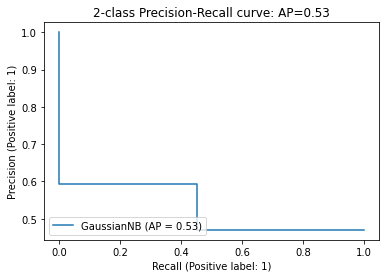

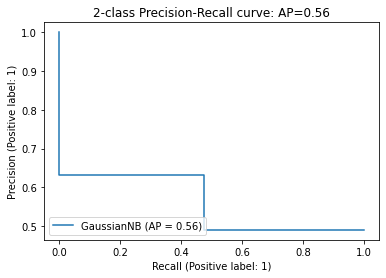

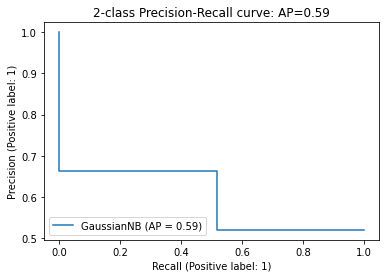

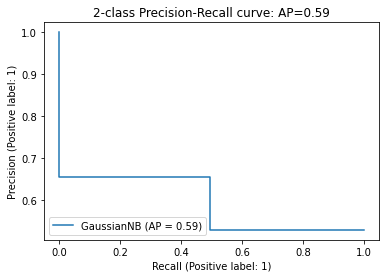

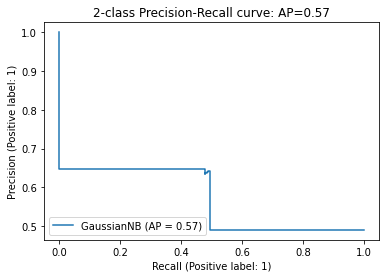

In [41]:
unigram_bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
run_naive(allData, "unigram BOW", unigram_bow_converter)

### run naive bayes on Bigram BOW

unigram BOW  model score:  0.66


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.725


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.6775


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.695


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.6975


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


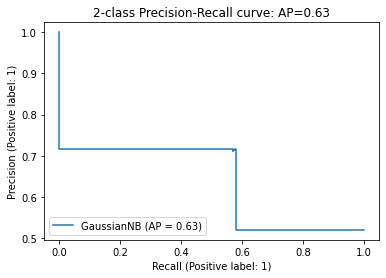

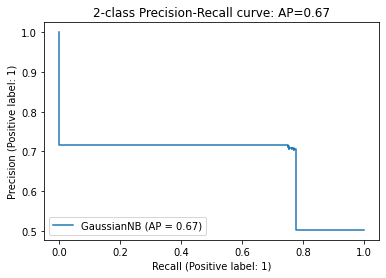

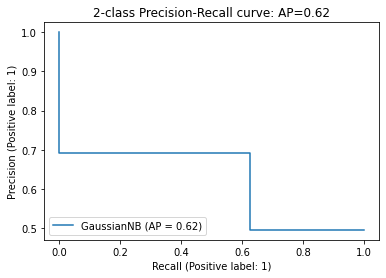

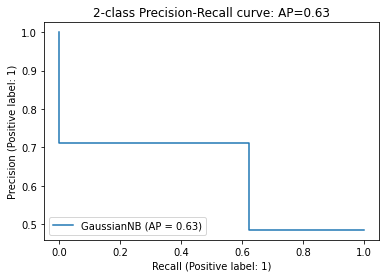

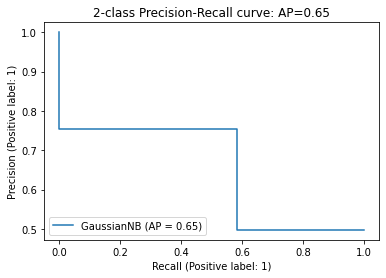

In [45]:
bigram_bow_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
run_naive(allData, "bigram BOW", bigram_bow_converter)

### run naive bayes on trigram BOW

unigram BOW  model score:  0.5925


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.5825


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.6175


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.59


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


unigram BOW  model score:  0.5725


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


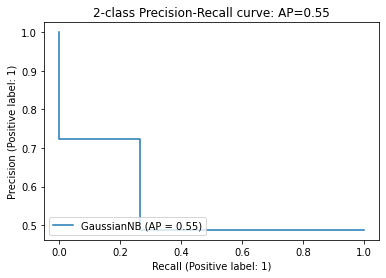

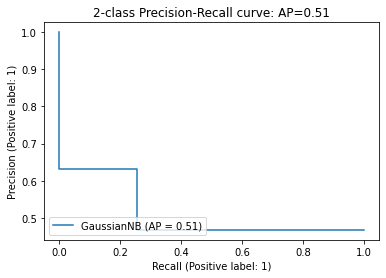

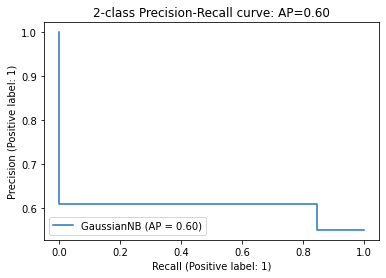

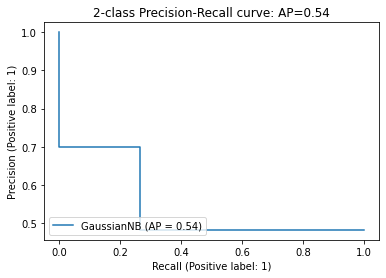

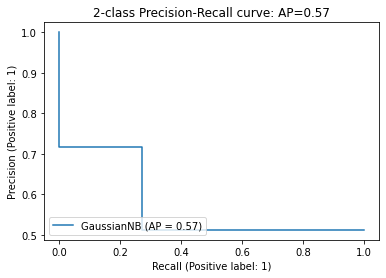

In [46]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
run_naive(allData, "trigram BOW", trigram_converter)

### run naive on gensim sentence embeddings

gensim embeddings  model score:  0.6


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


gensim embeddings  model score:  0.635


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


gensim embeddings  model score:  0.73


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


gensim embeddings  model score:  0.65


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


gensim embeddings  model score:  0.6625


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


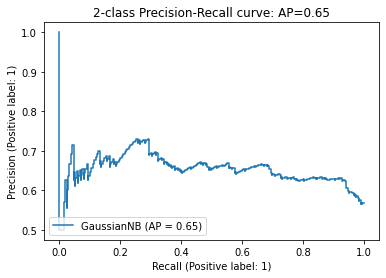

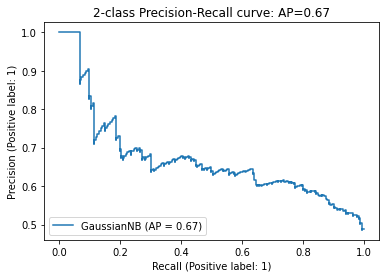

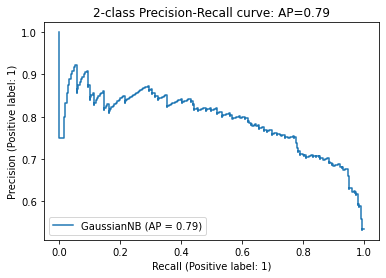

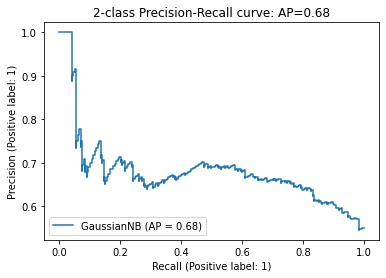

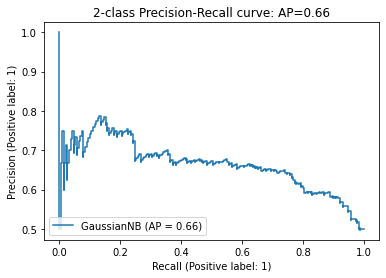

In [47]:
run_naive_sentence_embeddings(allData, "gensim embeddings")